<a href="https://colab.research.google.com/github/wh1t3tea/cv/blob/main/SpringfieldDatasetClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import  DataLoader, Dataset, ConcatDataset
import matplotlib.image as mpg
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from collections import Counter

Kaggle: wanna d1e
https://www.kaggle.com/wannad1e

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd

-rw-r--r-- 1 root root 64 Nov 11 10:36 kaggle.json
/content


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download journey-springfield

 99% 515M/521M [00:06<00:00, 92.1MB/s]
100% 521M/521M [00:06<00:00, 83.3MB/s]


In [ ]:
!unzip -q /content/journey-springfield.zip -d journey-springfield

In [ ]:
train_data_path = '/content/journey-springfield/train/simpsons_dataset'
test_data_path = '/content/journey-springfield/testset'
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_origin_image_folder = ImageFolder(root=train_data_path, transform=transform)
train_augmented_image_folder = ImageFolder(root=train_data_path, transform=augmented_transform)
train_image_folder = ConcatDataset([train_origin_image_folder, train_augmented_image_folder])

class_labels = [label for _, label in train_origin_image_folder.samples]
class_counts = Counter(class_labels)
total_samples = len(train_image_folder)
class_weights = [total_samples / (class_counts[i] * len(class_counts)) for i in class_labels]
sampler = WeightedRandomSampler(class_weights, num_samples=len(train_image_folder), replacement=True)

test_image_folder = ImageFolder(root=test_data_path, transform=transform)

In [ ]:
batch_size=64
train_loader = DataLoader(train_image_folder, batch_size=batch_size, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_image_folder, shuffle=False)

In [ ]:
len(train_loader)

655

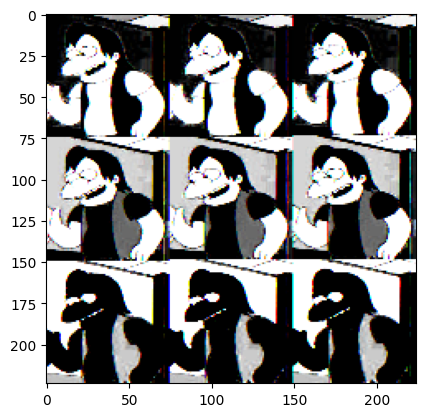

In [ ]:
plt.imshow(next(iter(test_loader))[0].reshape(224, 224, 3))

In [ ]:
out_features = len(set(class_labels))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision.models import resnet50, vgg19_bn, inception_v3, ResNet50_Weights, resnet34

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, out_features)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from tqdm.autonotebook import tqdm, trange
from torch.optim import lr_scheduler
import time

<ipython-input-15-5e6d30b81c69>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
cnt = 0
for param in model.parameters():
    cnt += 1
    if cnt >= 160:
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
for param in model.fc.parameters():
  print(param.requires_grad)

True
True


In [ ]:
def train_model(model, lr_scheduler, loss_fn, optimizer, epochs):

  tr_loss_list = []

  for epoch in range(epochs):

    epoch_loss = 0
    model.train()

    for xbatch, ybatch in train_loader:

      xbatch, ybatch = xbatch.to(device), ybatch.to(device)

      optimizer.zero_grad()
      outp = model(xbatch)
      loss = loss_fn(outp, ybatch)
      epoch_loss += loss
      loss.backward()
      optimizer.step()
    tr_loss_list.append(epoch_loss/len(train_loader))
    lr_scheduler.step()

    print(f'Epoch {epoch+1}: Train Loss = {tr_loss_list[-1]},  lr = {lr_scheduler.get_last_lr()[0]}')

  return tr_loss_list

In [ ]:
resnet_losses = train_model(model,
                            lr_scheduler=exp_lr_scheduler,
                            loss_fn=loss_fn,
                            optimizer=optimizer_ft,
                            epochs=15
                            )

Epoch 1: Train Loss = 1.4470767974853516,  lr = 0.001
Epoch 2: Train Loss = 0.5321993827819824,  lr = 0.001
Epoch 3: Train Loss = 0.345723956823349,  lr = 0.001
Epoch 4: Train Loss = 0.2524733543395996,  lr = 0.001
Epoch 5: Train Loss = 0.20311295986175537,  lr = 0.001
Epoch 6: Train Loss = 0.1693883240222931,  lr = 0.001
Epoch 7: Train Loss = 0.1444271057844162,  lr = 0.0001
Epoch 8: Train Loss = 0.12770189344882965,  lr = 0.0001
Epoch 9: Train Loss = 0.12327488511800766,  lr = 0.0001
Epoch 10: Train Loss = 0.12280648201704025,  lr = 0.0001
Epoch 11: Train Loss = 0.12283478677272797,  lr = 0.0001
Epoch 12: Train Loss = 0.11518839001655579,  lr = 0.0001
Epoch 13: Train Loss = 0.11617707461118698,  lr = 0.0001
Epoch 14: Train Loss = 0.1151970699429512,  lr = 1e-05
Epoch 15: Train Loss = 0.11427409946918488,  lr = 1e-05


In [ ]:
model_2 = resnet34(weights=None)
model_2.fc = nn.Linear(512, 42)
model_2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_2.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
resnet34_res = train_model(model_2,
            lr_scheduler=exp_lr_scheduler,
            loss_fn=loss_fn,
            optimizer=optimizer_ft,
            epochs=15)


Epoch 1: Train Loss = 1.413986086845398,  lr = 0.001
Epoch 2: Train Loss = 0.3799011707305908,  lr = 0.001
Epoch 3: Train Loss = 0.22231125831604004,  lr = 0.001
Epoch 4: Train Loss = 0.15811286866664886,  lr = 0.001
Epoch 5: Train Loss = 0.12629957497119904,  lr = 0.001
Epoch 6: Train Loss = 0.10352300852537155,  lr = 0.001
Epoch 7: Train Loss = 0.08952202647924423,  lr = 0.001
Epoch 8: Train Loss = 0.07750014960765839,  lr = 0.001
Epoch 9: Train Loss = 0.06895293295383453,  lr = 0.001
Epoch 10: Train Loss = 0.04923923313617706,  lr = 0.0001
Epoch 11: Train Loss = 0.019708912819623947,  lr = 0.0001
Epoch 12: Train Loss = 0.009387688711285591,  lr = 0.0001
Epoch 13: Train Loss = 0.005893274210393429,  lr = 0.0001
Epoch 14: Train Loss = 0.006326216738671064,  lr = 0.0001
Epoch 15: Train Loss = 0.004908915143460035,  lr = 0.0001


In [ ]:
torch.save(model_2.state_dict(), 'model_params.pt')

In [ ]:
resnet50 = [x.to('cpu').detach().numpy() for x in resnet_losses]
resnet34 = [x.to('cpu').detach().numpy() for x in resnet34_res]

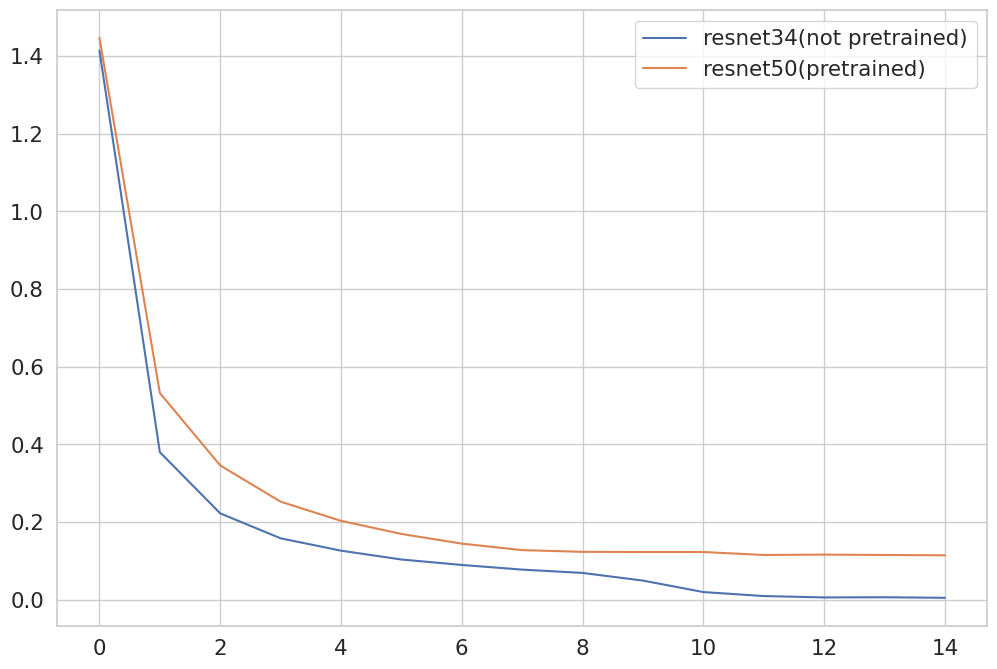

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(resnet34, label="resnet34(not pretrained)")
plt.plot(resnet50, label="resnet50(pretrained)")
plt.legend()
plt.show()

In [ ]:
resnet34_model = model_2

In [ ]:
y_test = []

resnet34_model.eval()
with torch.inference_mode():

  for xb, yb in test_loader:

    xb, yb = xb.to(device), yb.to(device)

    batch_logits = resnet34_model(xb)
    predictions = F.softmax(batch_logits, dim=-1)
    predictions = predictions.argmax(-1)
    y_test.append(predictions.item())

In [ ]:
from pathlib import Path
import pandas as pd

test_folder = '/content/journey-springfield/testset/testset'
test_path = 'testset/testset'
test_files = sorted(list(Path(test_folder).rglob('*.jpg')))
preds = y_test

submit = pd.DataFrame(columns=['Id'])

test_filenames = [path.name for path in test_files]
submit['Id'] = test_filenames
submit['Expected'] = [train_origin_image_folder.classes[pred] for pred in preds]
submit.sort_values(by=['Id'])
submit.to_csv('submission.csv', index=False)

In [ ]:
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [ ]:
!kaggle competitions submit -c journey-springfield -f /content/submission.csv -m "Maslov_Maxim_322583948"

100% 25.8k/25.8k [00:01<00:00, 23.0kB/s]
Successfully submitted to Journey to Springfield

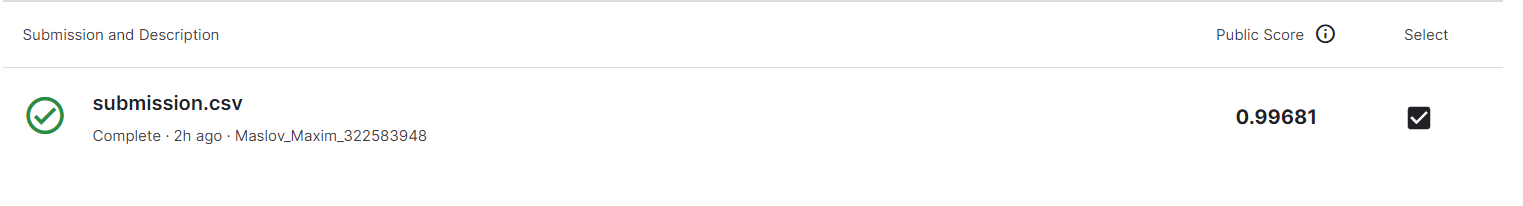